# A Comparison of State Use of SFLRF Funds for Vaccination Programs and Vaccination Rates in Each State

### Data Sources:
CDC - "COVID-19 Vaccinations in the United States, Jurisdiction"
csv downloaded 5/11/23
https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc

EARN/EPI - "EARN SLFRF Workbook for Q4 2022" compiled by Dave Kamper of the Economic Policy Institute (dkamper@epi.org) from Treasury reports by states and local jurisidictions who received funding, and other data sources as detailed in the workbook.

# Imports - Aaliyah, Evan, Greg, Joanna, Kendal

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from pathlib import Path
from scipy.stats import linregress
import scipy.stats as st
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
### Hide error messages
pd.options.mode.chained_assignment = None  # default='warn'

# Data Cleaning - Mostly Evan & Aaliyah

In [3]:
### Load csv file(s)
all_states_sheet = Path("Resources/EARN_all_states.csv")
state_summary_sheet = Path("Resources/state_summary.csv")

### Read csv file(s) as DataFrames
all_states_df = pd.read_csv(all_states_sheet, skipinitialspace= True, low_memory=False)
state_summary_df = pd.read_csv(state_summary_sheet, skipinitialspace= True)
vac_df = pd.read_csv('Resources/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv')
vac_df_2 = pd.read_csv('Resources/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv')

#change location to match state code
vac_df['Location'] = vac_df['Location'].str.replace('US_', '')

#remove spaces at the beginning and end of the string
all_states_df.columns = all_states_df.columns.str.strip()


C:\Users\EvanS\AppData\Local\Temp\ipykernel_1128\1867309782.py:8: DtypeWarning: Columns (7,8,10,11,15,16,22,25,26,32,34,42,44,53,55,56,57,58,59,60,61,62,71,73,75,77,79,81,83,84,85,86,87,88,90,92,93,94,95,96,97,98,99,100,101,103,105,107) have mixed types. Specify dtype option on import or set low_memory=False.
  vac_df = pd.read_csv('Resources/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv')
C:\Users\EvanS\AppData\Local\Temp\ipykernel_1128\1867309782.py:9: DtypeWarning: Columns (7,8,10,11,15,16,22,25,26,32,34,42,44,53,55,56,57,58,59,60,61,62,71,73,75,77,79,81,83,84,85,86,87,88,90,92,93,94,95,96,97,98,99,100,101,103,105,107) have mixed types. Specify dtype option on import or set low_memory=False.
  vac_df_2 = pd.read_csv('Resources/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv')


In [4]:
vac_df

Date  MMWR_week Location Distributed Distributed_Janssen  \
0      05/10/2023         19       NE   5,481,710             152,400   
1      05/10/2023         19       LA  10,282,120             330,500   
2      05/10/2023         19       GA  28,727,475             869,100   
3      05/10/2023         19       WY   1,281,755              49,300   
4      05/10/2023         19       CO  17,769,135             501,900   
...           ...        ...      ...         ...                 ...   
38483  12/13/2020         51       AS       3,900                   0   
38484  12/13/2020         51       VI         975                   0   
38485  12/13/2020         51       MP       4,875                   0   
38486  12/13/2020         51       US      13,650                   0   
38487  12/13/2020         51       GU       3,900                   0   

      Distributed_Moderna Distributed_Pfizer Distributed_Novavax  \
0               1,647,380          2,905,630               7,400   
1               3,807,980          5,164,550              10,100   
2               9,763,000         14,773,655              43,400   
3                 490,040            585,605               3,700   
4               5,402,640          9,029,715              43,600   
...                   ...                ...                 ...   
38483                   0                  0                 NaN   
38484                   0                  0                 NaN   
38485                   0                  0                 NaN   
38486                   0                  0                 NaN   
38487                   0                  0                 NaN   

      Distributed_Unk_Manuf Dist_Per_100K  ... Dist_Bivalent_PFR  \
0                         0       283,379  ...           575,480   
1                         0       221,178  ...           640,590   
2                         0       270,569  ...         2,255,000   
3                         0       221,466  ...           102,510   
4                         0       308,560  ...         2,033,760   
...                     ...           ...  ...               ...   
38483                     0         7,003  ...               NaN   
38484                     0           931  ...               NaN   
38485                     0         8,570  ...               NaN   
38486                     0             4  ...               NaN   
38487                     0         2,353  ...               NaN   

      Dist_Bivalent_MOD Bivalent_Booster_5Plus Bivalent_Booster_5Plus_Pop_Pct  \
0               193,420                340,508                           18.9   
1               328,400                359,506                            8.3   
2             1,023,320              1,126,791                           11.3   
3                50,600                 65,920                           12.1   
4               757,520              1,268,501                           23.4   
...                 ...                    ...                            ...   
38483               NaN                    NaN                            NaN   
38484               NaN                    NaN                            NaN   
38485               NaN                    NaN                            NaN   
38486               NaN                    NaN                            NaN   
38487               NaN                    NaN                            NaN   

      Bivalent_Booster_12Plus Bivalent_Booster_12Plus_Pop_Pct  \
0                     332,054                            20.5   
1                     356,199                             9.1   
2                   1,103,841                            12.3   
3                      64,919                            13.2   
4                   1,229,981                            24.9   
...                       ...                             ...   
38483                     NaN                             NaN   
38484    

### *EARN - Initial Data Cleaning* - Mostly Evan and Aaliyah

In [5]:
### Drop rows where the column has NaN value in all_states_df
    # source: https://towardsdatascience.com/how-to-drop-rows-in-pandas-dataframes-with-nan-values-in-certain-columns-7613ad1a7f25
    
all_states_df = all_states_df.dropna(subset=['Project Description'], how='all')

In [6]:
### Make the Project Description values all lowercase for value search in all_states_df:
all_states_df['Project Description'] = all_states_df['Project Description'].str.lower()

In [7]:
### Create dictionary in order to add a column of state name abbreviations to any DF:
    # source: https://gist.github.com/rogerallen/1583593

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}

In [8]:
### Selecting the desired columns in state_summary_df and saving as new, reduced_df
reduced_df = state_summary_df[['State', 'Total state allocation (from the fed)',
                               'total state plus total local federal grant',
                               'Share of state allocation spent', 'Share of state allocation obligated',
                               'Share of state allocation budgeted', 'Total local allocation (from the fed)',
                               'Share of local spent', 'Share of local obligated', 'Share of local budgeted',
                               'Share of state + local spent']]



reduced_df['State'] = reduced_df['State'].replace('_',' ', regex=True)

### add abbreviated state name column and reorder so the abbrev is after full state name column:
reduced_df['Location'] = reduced_df['State'].map(us_state_to_abbrev)


reduced_df.rename(columns = {'State':'State/Territory'}, inplace = True)

In [9]:
### convert all budget columns to numeric values for reduced_df
### drop non-number values first:

reduced_df[['Total state allocation (from the fed)', 
            'total state plus total local federal grant',
            'Total local allocation (from the fed)']] = reduced_df[['Total state allocation (from the fed)', 
            'total state plus total local federal grant',
            'Total local allocation (from the fed)']].replace(['\$', '-', ' '] ,'', regex=True)


numeric_cols = ['Total state allocation (from the fed)', 
            'total state plus total local federal grant',
            'Total local allocation (from the fed)']


### convert budget columns to int for summarizing in groupby:
reduced_df = reduced_df.replace(',','', regex=True)
reduced_df[numeric_cols] = reduced_df[numeric_cols].apply(pd.to_numeric)

In [10]:
### Now replace percentage string values with a decimal float value dtype:
    # reduced_df[['Share of state allocation spent', 'Share of state allocation obligated', 'Share of state allocation budgeted']] = reduced_df[['Share of state allocation spent', 'Share of state allocation obligated', 'Share of state allocation budgeted']].str.rstrip('%').astype('float') / 100.0

convert_cols = ['Share of state allocation spent', 'Share of state allocation obligated', 'Share of state allocation budgeted', 'Share of local spent', 'Share of local obligated', 'Share of local budgeted', 'Share of state + local spent']

reduced_df = reduced_df.replace('%','', regex=True)

reduced_df[convert_cols] = reduced_df[convert_cols].astype(float)/100

### *CDC Vaccination - Initial Data Cleaning - *** - Greg's function, further data cleaning by Joanna

In [11]:
#function formats the CDC dataframe for US jursdictions - see below for input formats
def CDC_format(df,key,date,add_str,drop_values): #key, filt -> str; length -> int; columns, drop_values -> list
    df = df.dropna(subset=[key])
    df = df[df['Date'] == date]
    df = df[~df[key].isin(drop_values)]
    #df[key] = add_str + df[key].astype(str)
    df.reset_index(drop = True, inplace = True)
    return df

In [12]:
drop = ['DD2','FM','AS','VI','BP2','IH2','GU','PN','PR','VA2','PW','US','MP','MH']
vac_df = CDC_format(vac_df,'Location','12/28/2022','US_',drop)
vac_df_2 = CDC_format(vac_df,'Location','12/28/2022','US_',drop)
vac_df

Date  MMWR_week Location  Distributed Distributed_Janssen  \
0   12/28/2022         52       CT   11,421,135             352,900   
1   12/28/2022         52       NJ   28,223,715           1,010,300   
2   12/28/2022         52       OK    9,308,930             338,700   
3   12/28/2022         52       NE    5,229,080             152,000   
4   12/28/2022         52       DE    3,169,595             101,900   
5   12/28/2022         52       ME    4,718,980             158,400   
6   12/28/2022         52       HI    4,448,760             124,900   
7   12/28/2022         52       AZ   19,039,550             618,600   
8   12/28/2022         52       KY   11,589,155             392,900   
9   12/28/2022         52       VT    2,444,660              74,200   
10  12/28/2022         52       IA    8,902,275             292,700   
11  12/28/2022         52       MD   21,286,570             616,000   
12  12/28/2022         52       AR    8,034,900             263,600   
13  12/28/2022         52       NM    5,914,665             190,400   
14  12/28/2022         52       NV    7,413,730             260,100   
15  12/28/2022         52       WI   15,646,525             456,400   
16  12/28/2022         52       IL   36,586,985           1,182,100   
17  12/28/2022         52       FL   58,979,615           2,460,700   
18  12/28/2022         52       KS    7,960,795             261,000   
19  12/28/2022         52       MS    6,967,035             233,800   
20  12/28/2022         52       OR   13,445,145             466,200   
21  12/28/2022         52       MT    2,606,775             106,400   
22  12/28/2022         52       RI    3,381,695              90,600   
23  12/28/2022         52       WV    5,268,855             171,400   
24  12/28/2022         52       OH   30,173,705           1,009,200   
25  12/28/2022         52       VA   25,592,245             802,500   
26  12/28/2022         52       TX   77,173,045           2,662,600   
27  12/28/2022         52       NY   58,677,865           1,956,500   
28  12/28/2022         52       DC    2,617,105              72,700   
29  12/28/2022         52       PA   40,583,485           1,564,300   
30  12/28/2022         52       MN   17,484,960             510,500   
31  12/28/2022         52       IN   17,931,670             630,200   
32  12/28/2022         52       NC   28,892,660             953,900   
33  12/28/2022         52       GA   27,477,235             862,300   
34  12/28/2022         52       ND    1,819,400              53,600   
35  12/28/2022         52       SC   13,521,655             464,500   
36  12/28/2022         52       SD    2,554,375              93,500   
37  12/28/2022         52       UT    8,077,190             256,600   
38  12/28/2022         52       MA   22,540,490             631,100   
39  12/28/2022         52       AK    2,066,295              86,200   
40  12/28/2022         52       MO   14,992,925             439,500   
41  12/28/2022         52       AL   11,897,230             402,100   
42  12/28/2022         52       TN   16,493,260             529,600   
43  12/28/2022         52       WY    1,241,825              49,300   
44  12/28/2022         52       WA   24,157,865             776,000   
45  12/28/2022         52       CO   16,867,685             500,700   
46  12/28/2022         52       ID    4,537,400             160,000   
47  12/28/2022         52       CA  115,820,215           3,778,100   
48  12/28/2022         52       LA    9,957,190             329,600   
49  12/28/2022         52       MI   28,196,080             964,500   
50  12/28/2022         52       NH    4,844,640             188,600   

   Distributed_Moderna Distributed_Pfizer Distributed_Novavax  \
0            4,425,580          6,634,455               8,200   
1            9,998,740         17,181,675              33,000   
2            3,841,880          5,105,950              22,400   
3            1,775,380          3,296,200               5

In [13]:
# get all the columns we will be interested in into one dataframe
# NOTE: there is no Pop_Pct column for the administered_bivalent, and second_booster only for the age breakouts
# but we can extrapolate from their other population calculations to calculate these. For second_booster to get state numbers
# we have to add up the vaccines from the different manufacturers because we don't have them already summed.

vac_df = pd.DataFrame(data=vac_df, columns=["Location", "Distributed", "Administered", "Recip_Administered",
                                                   "Administered_Dose1_Recip", "Administered_Dose1_Pop_Pct",
                                                   "Administered_Dose1_Recip_5Plus", "Administered_Dose1_Recip_5PlusPop_Pct",
                                                  "Administered_Dose1_Recip_12Plus", "Administered_Dose1_Recip_12PlusPop_Pct",
                                                  "Administered_Dose1_Recip_18Plus", "Administered_Dose1_Recip_18PlusPop_Pct",
                                                  "Administered_Dose1_Recip_65Plus", "Administered_Dose1_Recip_65PlusPop_Pct",
                                                  "Series_Complete_Yes", "Series_Complete_Pop_Pct", "Series_Complete_5Plus",
                                                "Series_Complete_5PlusPop_Pct", "Series_Complete_12Plus",
                                                "Series_Complete_12PlusPop_Pct", "Series_Complete_18Plus",
                                                "Series_Complete_18PlusPop_Pct", "Series_Complete_65Plus",
                                                "Series_Complete_65PlusPop_Pct", "Additional_Doses",
                                                   "Additional_Doses_Vax_Pct", "Additional_Doses_5Plus",
                                                   "Additional_Doses_5Plus_Vax_Pct", "Additional_Doses_12Plus",
                                                   "Additional_Doses_12Plus_Vax_Pct", "Additional_Doses_18Plus",
                                                   "Additional_Doses_18Plus_Vax_Pct", "Additional_Doses_50Plus",
                                                   "Additional_Doses_50Plus_Vax_Pct", "Additional_Doses_65Plus",
                                                   "Additional_Doses_65Plus_Vax_Pct", "Second_Booster_50Plus",
                                                   "Second_Booster_50Plus_Vax_Pct", "Second_Booster_65Plus",
                                                   "Second_Booster_65Plus_Vax_Pct", "Second_Booster_Janssen",
                                                    "Second_Booster_Moderna", "Second_Booster_Pfizer",
                                                    "Second_Booster_Unk_Manuf", "Administered_Bivalent",
                                                   "Bivalent_Booster_5Plus", "Bivalent_Booster_5Plus_Pop_Pct",
                                                   "Bivalent_Booster_12Plus", "Bivalent_Booster_12Plus_Pop_Pct",
                                                   "Bivalent_Booster_18Plus", "Bivalent_Booster_18Plus_Pop_Pct",
                                                "Bivalent_Booster_65Plus", "Bivalent_Booster_65Plus_Pop_Pct"])

In [14]:
# remove commas from numeric columns
# convert numeric columns to correct type
vac_df = vac_df.replace(',','', regex=True)
numeric_cols = ["Distributed", "Administered", "Recip_Administered", "Administered_Dose1_Recip", "Administered_Dose1_Pop_Pct",
                "Administered_Dose1_Recip_5Plus", "Administered_Dose1_Recip_5PlusPop_Pct", "Administered_Dose1_Recip_12Plus",
                "Administered_Dose1_Recip_12PlusPop_Pct", "Administered_Dose1_Recip_18Plus",
                "Administered_Dose1_Recip_18PlusPop_Pct", "Administered_Dose1_Recip_65Plus",
                "Administered_Dose1_Recip_65PlusPop_Pct", "Series_Complete_Yes", "Series_Complete_Pop_Pct",
                "Series_Complete_5Plus", "Series_Complete_12Plus", "Series_Complete_12PlusPop_Pct", "Series_Complete_18Plus",
                "Series_Complete_18PlusPop_Pct", "Series_Complete_65Plus", "Series_Complete_65PlusPop_Pct", "Additional_Doses",
                "Additional_Doses_Vax_Pct", "Additional_Doses_5Plus", "Additional_Doses_5Plus_Vax_Pct", "Additional_Doses_12Plus",
                "Additional_Doses_12Plus_Vax_Pct", "Additional_Doses_18Plus", "Additional_Doses_18Plus_Vax_Pct",
                "Additional_Doses_50Plus", "Additional_Doses_50Plus_Vax_Pct", "Additional_Doses_65Plus",
                "Additional_Doses_65Plus_Vax_Pct", "Second_Booster_50Plus", "Second_Booster_50Plus_Vax_Pct",
                "Second_Booster_65Plus", "Second_Booster_65Plus_Vax_Pct", "Second_Booster_Janssen",
                "Second_Booster_Moderna", "Second_Booster_Pfizer", "Second_Booster_Unk_Manuf", "Administered_Bivalent",
                "Bivalent_Booster_5Plus", "Bivalent_Booster_5Plus_Pop_Pct", "Bivalent_Booster_12Plus",
                "Bivalent_Booster_12Plus_Pop_Pct", "Bivalent_Booster_18Plus", "Bivalent_Booster_18Plus_Pop_Pct"]
vac_df[numeric_cols] = vac_df[numeric_cols].apply(pd.to_numeric)

In [15]:
#create df with only columns related to choropleth maps

#change location to match state code for choropleth maps
vac_df_2['Location'] = vac_df_2['Location'].str.replace('US_', '')

choropleth_vac_df = vac_df_2[['Location', 
                            'Distributed', 
                            'Administered', 
                            'Administered_Dose1_Pop_Pct', 
                            'Series_Complete_Pop_Pct', 
                            'Series_Complete_5PlusPop_Pct', 
                            'Series_Complete_12PlusPop_Pct', 
                            'Series_Complete_18PlusPop_Pct', 
                            'Series_Complete_65PlusPop_Pct', 
                            'Additional_Doses_Vax_Pct', 
                            'Additional_Doses_65Plus_Vax_Pct', 
                            'Second_Booster_65Plus_Vax_Pct', 
                            'Bivalent_Booster_5Plus_Pop_Pct', 
                            'Bivalent_Booster_12Plus_Pop_Pct', 
                            'Bivalent_Booster_18Plus_Pop_Pct', 
                            'Bivalent_Booster_65Plus_Pop_Pct']]
choropleth_vac_df

Location  Distributed Administered  Administered_Dose1_Pop_Pct  \
0        CT   11,421,135    8,883,525                        95.0   
1        NJ   28,223,715   19,503,839                        94.3   
2        OK    9,308,930    6,660,547                        74.3   
3        NE    5,229,080    3,735,602                        73.1   
4        DE    3,169,595    2,120,412                        87.7   
5        ME    4,718,980    3,458,390                        95.0   
6        HI    4,448,760    3,451,416                        91.1   
7        AZ   19,039,550   14,302,488                        77.1   
8        KY   11,589,155    7,392,531                        68.6   
9        VT    2,444,660    1,718,359                        95.0   
10       IA    8,902,275    6,014,512                        70.4   
11       MD   21,286,570   14,414,405                        91.3   
12       AR    8,034,900    4,803,994                        69.6   
13       NM    5,914,665    4,649,331                        93.8   
14       NV    7,413,730    5,505,852                        77.3   
15       WI   15,646,525   12,187,825                        74.9   
16       IL   36,586,985   26,360,133                        78.9   
17       FL   58,979,615   41,494,703                        82.1   
18       KS    7,960,795    5,282,684                        75.9   
19       MS    6,967,035    4,248,212                        61.5   
20       OR   13,445,145    9,166,670                        81.2   
21       MT    2,606,775    1,830,798                        68.0   
22       RI    3,381,695    2,610,412                        95.0   
23       WV    5,268,855    3,063,510                        67.3   
24       OH   30,173,705   20,717,062                        65.5   
25       VA   25,592,245   19,227,095                        90.6   
26       TX   77,173,045   51,483,870                        76.0   
27       NY   58,677,865   44,418,984                        94.1   
28       DC    2,617,105    1,930,871                        95.0   
29       PA   40,583,485   26,925,901                        90.1   
30       MN   17,484,960   12,533,992                        78.5   
31       IN   17,931,670   11,008,571                        64.2   
32       NC   28,892,660   19,210,889                        91.6   
33       GA   27,477,235   16,829,103                        68.1   
34       ND    1,819,400    1,288,199                        69.1   
35       SC   13,521,655    8,522,851                        70.7   
36       SD    2,554,375    1,656,461                        83.4   
37       UT    8,077,190    6,037,264                        75.0   
38       MA   22,540,490   17,765,199                        95.0   
39       AK    2,066,295    1,303,955                        72.8   
40       MO   14,992,925   10,338,822                        69.1   
41       AL   11,897,230    6,929,554                        64.8   
42       TN   16,493,260   11,173,141                        64.3   
43       WY    1,241,825      844,861                        60.7   
44       WA   24,157,865   17,293,339                        84.9   
45       CO   16,867,685   12,765,099                        83.3   
46       ID    4,537,400    2,837,380                        63.7   
47       CA  115,820,215   86,604,013                        84.3   
48       LA    9,957,190    6,870,075                        62.7   
49       MI   28,196,080   18,399,849                        69.3   
50       NH    4,844,640    2,906,126                        87.5   

    Series_Complete_Pop_Pct  Series_Complete_5PlusPop_Pct  \
0                      82.8                          86.8   
1                      78.8                          83.3   
2                      60.2                          64.3   
3                      66.0                          70.4   
4                      72.9                          77.0   
5                      83.0                     

### *Creating New DataFrames for Analysis -* -- Aaliyah, Evan, Greg, Joanna, and Kendal (please check this area)

In [16]:
## Brainstorm a list of words to filter the 'Project Description' column by.
    # this list will be used to filter that column so that we are only working with projects that
    # are actually vaccine related.

search_term_list = ['immunize', 'immunization','access to vaccines', 'spikevax', 'bivalent', 'novavax', 'two-dose', 
                    'single-dose', 'emergency use authoriztaion', 'vaccine coverage', 
                    'vaccine access', 'vaccine distribution', 'distribute vaccines', 'vaccine', 'vaccination', 'vaccinate', 'moderna', 'pfizer', 'johnson & johnson', 'janssen']

covid_projects_df = all_states_df[all_states_df['Project Description'].str.contains('|'.join(search_term_list))]



In [17]:
### Clean up values preventing change of data type to int
covid_projects_df[['Adopted Budget','Total Cumulative Obligations','Total Cumulative Expenditures']] = covid_projects_df[['Adopted Budget','Total Cumulative Obligations', 'Total Cumulative Expenditures']].replace(['-', ' '] ,'', regex=True)


numeric_cols = ['Adopted Budget','Total Cumulative Obligations', 'Total Cumulative Expenditures']


### Convert budget columns to int for summarizing in groupby:
covid_projects_df = covid_projects_df.replace(',','', regex=True)
covid_projects_df[numeric_cols] = covid_projects_df[numeric_cols].apply(pd.to_numeric)


In [18]:
### Group the filtered dataframe by state, summing applicable $ value columns
    # if errors, clean columns causing errors. 
    # eg) 'Adopted Budget' column has values containing "-". This might prevent the .sum() function from working

covid_sums_df = covid_projects_df.groupby(['State/Territory'], as_index=False).sum(['Adopted Budget', 'Total Cumulative Obligations', 
                                                                        'Total Cumulative Expenditures'])

### add abbreviated state name column and reorder so the abbrev is after full state name column:
covid_sums_df['Location'] = covid_sums_df['State/Territory'].map(us_state_to_abbrev)
covid_sums_df = covid_sums_df[['State/Territory', 'Location', 'Adopted Budget', 
                                       'Total Cumulative Obligations', 'Total Cumulative Expenditures']]
covid_counts_df = covid_projects_df.groupby(['State/Territory'], as_index=False).count()[['State/Territory', 'Project ID']]

### Now merge the vaccine projects count by state onto the state_spending_df:

state_spending_df = pd.merge(covid_sums_df, covid_counts_df, how ='inner', on =('State/Territory'))
### Rename the counted 'Project ID' column for clarity:
state_spending_df.rename(columns = {'Project ID':'Count of Vaccine Projects'}, inplace = True)


In [19]:
### merge this data frame with Evan's "state_spending_df". Merge on the state columns.
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
    # https://www.geeksforgeeks.org/how-to-join-pandas-dataframes-using-merge/#

### EARN_states combines the three budget columns from "All_US_Projects" sheet with the entire "State Summary Table" sheet.
### The three budget columns are filtered for covid projects, but all dollar value columns in the "State Summary Table" are not filtered by covid projects.

EARN_states = pd.merge(state_spending_df, reduced_df, how ='inner', on =(['State/Territory', 'Location']))


In [20]:
### Add column to show percent of fed money spent per State:
### [Total Cumulative Expenditures]/[total state plus total local federal grant]
### sortby this new percent column.

EARN_states['Percent Spent on Covid Projects'] = state_spending_df['Total Cumulative Expenditures']/EARN_states['total state plus total local federal grant']

EARN_states.sort_values(by=['Percent Spent on Covid Projects'], ascending=False, inplace= True)


In [21]:
### "all_us_projects_df" is for (2) from Joanna's slack message request:
all_us_projects_df = all_states_df[['Recipient Name', 'State/Territory', 'Recipient Type', 
                                    'Completion Status', 'Project Name', 'Expenditure Category Group', 'Expenditure Category', 
                                    'Project Description', 'Adopted Budget', 'Total Cumulative Obligations', 
                                    'Total Cumulative Expenditures']].copy()


all_us_projects_df['State/Territory'] = all_us_projects_df['State/Territory'].map(us_state_to_abbrev)
all_us_projects_df.rename(columns = {'State/Territory':'State'}, inplace = True)

all_us_projects_df[['Adopted Budget','Total Cumulative Obligations',
                   'Total Cumulative Expenditures']] = all_us_projects_df[['Adopted Budget',
       'Total Cumulative Obligations', 'Total Cumulative Expenditures']].replace(['-', ' '] ,'', regex=True)


numeric_cols = ['Adopted Budget',
       'Total Cumulative Obligations', 'Total Cumulative Expenditures']


### convert budget columns to int for summarizing in groupby:
all_us_projects_df = all_us_projects_df.replace(',','', regex=True)
all_us_projects_df[numeric_cols] = all_us_projects_df[numeric_cols].apply(pd.to_numeric)

In [22]:
### "us_covid_projects_df" is for (3) from Joanna's slack message:
us_covid_projects_df = all_us_projects_df[all_us_projects_df['Project Description'].str.contains('|'.join(search_term_list))]

# Analysis & Visualization - Mostly Greg, Joanna, and Kendal -- please check that the line regression stuff matches and that the DFs it is based on are as they should be

### *Line Regression -*

In [23]:
# calculate totals for second booster
vac_df["Second_Booster_Total"] = (vac_df["Second_Booster_Janssen"] + vac_df["Second_Booster_Moderna"]
                                + vac_df["Second_Booster_Pfizer"] + vac_df["Second_Booster_Unk_Manuf"])
# find their population number... ok this is off. ???
# I don't know why it is appearing they used different population numbers. Something is weird here. We could just use a number
# from the census, or just ignore the second booster.
vac_df["Pop1"] = vac_df["Series_Complete_Yes"] / (vac_df["Series_Complete_Pop_Pct"]/100)
vac_df["Pop2"] = vac_df["Administered_Dose1_Recip"] / (vac_df["Administered_Dose1_Pop_Pct"]/100)

vac_pops_df = pd.DataFrame(data=vac_df, columns=["Location", "Pop1", "Pop2"])


In [24]:
# df with vax data for all ages
vac_all_ages_df = pd.DataFrame(data=vac_df, columns=["Location", "Distributed", "Administered", "Recip_Administered",
                                                   "Administered_Dose1_Recip", "Administered_Dose1_Pop_Pct",
                                                    "Series_Complete_Yes", "Series_Complete_Pop_Pct",
                                                     "Additional_Doses", "Additional_Doses_Vax_Pct", "Administered_Bivalent"])

# add 'Dose Differential' column to track doses administered to nonresidents. Negative number = doses leaving the state
vac_all_ages_df["Dose Differential"] = vac_all_ages_df["Administered"] - vac_all_ages_df["Recip_Administered"]
vac_all_ages_df["Dose Diff. as Pct of Doses Given"] = abs(vac_all_ages_df["Dose Differential"] / vac_all_ages_df["Administered"])
vac_all_ages_df["Dose Diff. as Pct of Residents Vaxxed"] = abs(vac_all_ages_df["Dose Differential"] / vac_all_ages_df["Recip_Administered"])


In [25]:
# df with dose differential between doses administered in a state and doses received by residents of a state
vac_dd_df = pd.DataFrame(data=vac_all_ages_df, columns=["Location", "Distributed", "Administered", "Recip_Administered", "Dose Differential",
                         "Dose Diff. as Pct of Doses Given", "Dose Diff. as Pct of Residents Vaxxed", "Administered_Dose1_Pop_Pct", "Series_Complete_Pop_Pct",
                         "Additional_Doses_Vax_Pct"])

In [26]:
# get rows with negative dose differential (states that administered lots of vaccine to people living elsewhere)
# sort in order of large differentials to small (as percent of total doses given)
# for example: in NM at least 3.8% of the doses were given to people who lived elsewhere
vac_dd_neg_df = vac_dd_df[vac_dd_df['Dose Differential'] < 1]
vac_dd_neg_df = vac_dd_neg_df.sort_values(by=['Dose Diff. as Pct of Doses Given'], ascending=False)

In [27]:
# get rows with positive dose differential (states with a lot of residents who were vaccinated elsewhere)
# sort in order of large differentials to small (as percent of total doses given)
# for example: in Arizona, at least 2.6% of the vaccinated population received doses elsewhere.
vac_dd_pos_df = vac_dd_df[vac_dd_df['Dose Differential'] >= 1]
vac_dd_pos_df = vac_dd_pos_df.sort_values(by=['Dose Diff. as Pct of Residents Vaxxed'], ascending=False)

In [28]:
# Checking on second booster columns
vac_secondbooster_df = pd.DataFrame(data=vac_df, columns=["Location", "Second_Booster_50Plus",
                                                   "Second_Booster_50Plus_Vax_Pct", "Second_Booster_65Plus",
                                                   "Second_Booster_65Plus_Vax_Pct", "Second_Booster_Janssen",
                                                    "Second_Booster_Moderna", "Second_Booster_Pfizer",
                                                    "Second_Booster_Unk_Manuf"])

In [29]:
# find how many doses were distributed vs administered
# calculate percent
# sort alphabetically by state
vac_waste_df = pd.DataFrame(data=vac_df, columns=["Location", "Distributed", "Administered"])
vac_waste_df["Pct. Administered"] = vac_waste_df["Administered"] / vac_waste_df["Distributed"]
vac_waste_df.sort_values('Location')

Location  Distributed  Administered  Pct. Administered
39       AK      2066295       1303955           0.631059
41       AL     11897230       6929554           0.582451
12       AR      8034900       4803994           0.597891
7        AZ     19039550      14302488           0.751199
47       CA    115820215      86604013           0.747745
45       CO     16867685      12765099           0.756778
0        CT     11421135       8883525           0.777815
28       DC      2617105       1930871           0.737789
4        DE      3169595       2120412           0.668985
17       FL     58979615      41494703           0.703543
33       GA     27477235      16829103           0.612474
6        HI      4448760       3451416           0.775815
10       IA      8902275       6014512           0.675615
46       ID      4537400       2837380           0.625332
16       IL     36586985      26360133           0.720478
31       IN     17931670      11008571           0.613918
18       KS      7960795       5282684           0.663587
8        KY     11589155       7392531           0.637884
48       LA      9957190       6870075           0.689961
38       MA     22540490      17765199           0.788146
11       MD     21286570      14414405           0.677160
5        ME      4718980       3458390           0.732868
49       MI     28196080      18399849           0.652568
30       MN     17484960      12533992           0.716844
40       MO     14992925      10338822           0.689580
19       MS      6967035       4248212           0.609759
21       MT      2606775       1830798           0.702323
32       NC     28892660      19210889           0.664906
34       ND      1819400       1288199           0.708035
3        NE      5229080       3735602           0.714390
50       NH      4844640       2906126           0.599864
1        NJ     28223715      19503839           0.691044
13       NM      5914665       4649331           0.786068
14       NV      7413730       5505852           0.742656
27       NY     58677865      44418984           0.756997
24       OH     30173705      20717062           0.686593
2        OK      9308930       6660547           0.715501
20       OR     13445145       9166670           0.681783
29       PA     40583485      26925901           0.663469
22       RI      3381695       2610412           0.771924
35       SC     13521655       8522851           0.630311
36       SD      2554375       1656461           0.648480
42       TN     16493260      11173141           0.677437
26       TX     77173045      51483870           0.667122
37       UT      8077190       6037264           0.747446
25       VA     25592245      19227095           0.751286
9        VT      2444660       1718359           0.702903
44       WA     24157865      17293339           0.715847
15       WI     15646525      12187825           0.778948
23       WV      5268855       3063510           0.581438
43       WY      1241825        844861           0.680338

In [30]:
# Show best 10 states in vaccine distribution percentage
vac_waste_best_df = vac_waste_df.sort_values('Pct. Administered', ascending=False)
vac_waste_best_df.head(10)

Location  Distributed  Administered  Pct. Administered
38       MA     22540490      17765199           0.788146
13       NM      5914665       4649331           0.786068
15       WI     15646525      12187825           0.778948
0        CT     11421135       8883525           0.777815
6        HI      4448760       3451416           0.775815
22       RI      3381695       2610412           0.771924
27       NY     58677865      44418984           0.756997
45       CO     16867685      12765099           0.756778
25       VA     25592245      19227095           0.751286
7        AZ     19039550      14302488           0.751199

In [31]:
# Show worst 10 states in vaccine distribution percentage
vac_waste_worst_df = vac_waste_df.sort_values('Pct. Administered', ascending=True)
vac_waste_worst_df.head(10)

Location  Distributed  Administered  Pct. Administered
23       WV      5268855       3063510           0.581438
41       AL     11897230       6929554           0.582451
12       AR      8034900       4803994           0.597891
50       NH      4844640       2906126           0.599864
19       MS      6967035       4248212           0.609759
33       GA     27477235      16829103           0.612474
31       IN     17931670      11008571           0.613918
46       ID      4537400       2837380           0.625332
35       SC     13521655       8522851           0.630311
39       AK      2066295       1303955           0.631059

In [32]:
# whole pop info
# NOTE: There is no percentage for the entire pop for bivalent so included the 5+ pop. If we have time, will pull in the same
# census data they used to get the correct pct
# second booster only has 50+ and 65+ % -- I'm sure there must be some reason for this, not sure what
vac_whole_pop_df = pd.DataFrame(data=vac_df, columns=["Location", "Distributed", "Administered", "Recip_Administered",
                                                   "Administered_Dose1_Recip", "Administered_Dose1_Pop_Pct",
                                                   "Series_Complete_Yes", "Series_Complete_Pop_Pct", 
                                                    "Additional_Doses", "Additional_Doses_Vax_Pct", "Second_Booster_Total", 
                                                    "Second_Booster_Janssen", "Second_Booster_Moderna", "Second_Booster_Pfizer",
                                                    "Second_Booster_Unk_Manuf", "Administered_Bivalent", "Bivalent_Booster_5Plus", 
                                                      "Bivalent_Booster_5Plus_Pop_Pct"])

In [33]:
vac_5plus_df = pd.DataFrame(data=vac_df, columns=["Location", 
                                                   "Administered_Dose1_Recip_5Plus", "Administered_Dose1_Recip_5PlusPop_Pct",
                                                  "Series_Complete_5Plus", "Series_Complete_5PlusPop_Pct",
                                                   "Additional_Doses_5Plus", "Additional_Doses_5Plus_Vax_Pct", 
                                                   "Bivalent_Booster_5Plus", "Bivalent_Booster_5Plus_Pop_Pct"])

In [34]:
# 12 plus vaccinations
vac_12plus_df = pd.DataFrame(data=vac_df, columns=["Location", "Administered_Dose1_Recip_12Plus",
                                                   "Administered_Dose1_Recip_12PlusPop_Pct", "Series_Complete_12Plus",
                                                   "Series_Complete_12PlusPop_Pct", "Additional_Doses_12Plus",
                                                   "Additional_Doses_12Plus_Vax_Pct", "Bivalent_Booster_12Plus",
                                                   "Bivalent_Booster_12Plus_Pop_Pct"])

In [35]:
# 18 plus vaccinations
vac_18plus_df = pd.DataFrame(data=vac_df, columns=["Location", "Administered_Dose1_Recip_18Plus",
                                                   "Administered_Dose1_Recip_18PlusPop_Pct", "Series_Complete_18Plus",
                                                   "Series_Complete_18PlusPop_Pct", "Additional_Doses_18Plus",
                                                   "Additional_Doses_18Plus_Vax_Pct", "Bivalent_Booster_18Plus",
                                                   "Bivalent_Booster_18Plus_Pop_Pct"])

In [36]:
# 65 plus vaccinations
vac_65plus_df = pd.DataFrame(data=vac_df, columns=["Location", "Administered_Dose1_Recip_65Plus",
                                                   "Administered_Dose1_Recip_65PlusPop_Pct", "Series_Complete_65Plus",
                                                   "Series_Complete_65PlusPop_Pct", "Additional_Doses_65Plus",
                                                   "Additional_Doses_65Plus_Vax_Pct", "Second_Booster_50Plus",
                                                   "Second_Booster_50Plus_Vax_Pct", "Second_Booster_65Plus",
                                                   "Second_Booster_65Plus_Vax_Pct", "Bivalent_Booster_65Plus",
                                                   "Bivalent_Booster_65Plus_Pop_Pct"])

In [37]:
# first dose info

vac_firstdose_df = pd.DataFrame(data=vac_df, columns=["Location", "Administered_Dose1_Recip", "Administered_Dose1_Pop_Pct",
                                                   "Administered_Dose1_Recip_5Plus", "Administered_Dose1_Recip_5PlusPop_Pct",
                                                  "Administered_Dose1_Recip_12Plus", "Administered_Dose1_Recip_12PlusPop_Pct",
                                                  "Administered_Dose1_Recip_18Plus", "Administered_Dose1_Recip_18PlusPop_Pct",
                                                  "Administered_Dose1_Recip_65Plus", "Administered_Dose1_Recip_65PlusPop_Pct"])

In [38]:
# series complete info
vac_series_complete_df = pd.DataFrame(data=vac_df, columns=["Location", "Series_Complete_Yes", "Series_Complete_Pop_Pct",
                                                            "Series_Complete_5Plus", "Series_Complete_5PlusPop_Pct",
                                                            "Series_Complete_12Plus", "Series_Complete_12PlusPop_Pct",
                                                            "Series_Complete_18Plus", "Series_Complete_18PlusPop_Pct",
                                                            "Series_Complete_65Plus", "Series_Complete_65PlusPop_Pct"])

In [39]:
vac_additional_doses_df = pd.DataFrame(data=vac_df, columns=["Location", "Additional_Doses",
                                                   "Additional_Doses_Vax_Pct", "Additional_Doses_5Plus",
                                                   "Additional_Doses_5Plus_Vax_Pct", "Additional_Doses_12Plus",
                                                   "Additional_Doses_12Plus_Vax_Pct", "Additional_Doses_18Plus",
                                                   "Additional_Doses_18Plus_Vax_Pct", "Additional_Doses_50Plus",
                                                   "Additional_Doses_50Plus_Vax_Pct", "Additional_Doses_65Plus",
                                                   "Additional_Doses_65Plus_Vax_Pct"])

In [40]:
vac_second_booster_df = pd.DataFrame(data=vac_df, columns=["Location", "Second_Booster_50Plus",
                                                           "Second_Booster_50Plus_Vax_Pct", "Second_Booster_65Plus",
                                                           "Second_Booster_65Plus_Vax_Pct", "Second_Booster_Total",
                                                           "Second_Booster_Janssen", "Second_Booster_Moderna",
                                                           "Second_Booster_Pfizer", "Second_Booster_Unk_Manuf"])


In [41]:
vac_bivalent_df = pd.DataFrame(data=vac_df, columns=["Location", "Administered_Bivalent", "Bivalent_Booster_5Plus",
                                                     "Bivalent_Booster_5Plus_Pop_Pct", "Bivalent_Booster_12Plus",
                                                     "Bivalent_Booster_12Plus_Pop_Pct", "Bivalent_Booster_18Plus",
                                                     "Bivalent_Booster_18Plus_Pop_Pct", "Bivalent_Booster_65Plus",
                                                     "Bivalent_Booster_65Plus_Pop_Pct"])

In [42]:
vac_whole_pop_df.head()

Location  Distributed  Administered  Recip_Administered  \
0       CT     11421135       8883525             8933212   
1       NJ     28223715      19503839            20082553   
2       OK      9308930       6660547             6642791   
3       NE      5229080       3735602             3754048   
4       DE      3169595       2120412             2094422   

   Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  Series_Complete_Yes  \
0                   3636096                        95.0              2950962   
1                   8372496                        94.3              7001577   
2                   2940863                        74.3              2383051   
3                   1414102                        73.1              1276735   
4                    853776                        87.7               709932   

   Series_Complete_Pop_Pct  Additional_Doses  Additional_Doses_Vax_Pct  \
0                     82.8           1628555                      55.2   
1                     78.8           3611932                      51.6   
2                     60.2            986011                      41.4   
3                     66.0            703721                      55.1   
4                     72.9            361595                      50.9   

   Second_Booster_Total  Second_Booster_Janssen  Second_Booster_Moderna  \
0                657393                     116                  292804   
1               1178279                     906                  509117   
2                336701                     173                  148602   
3                296496                     124                  100170   
4                147425                      92                   61803   

   Second_Booster_Pfizer  Second_Booster_Unk_Manuf  Administered_Bivalent  \
0                 364453                        20                 782715   
1                 668184                        72                1241078   
2                 186591                      1335                 399410   
3                 195655                       547                 284855   
4                  85502                        28                 171972   

   Bivalent_Booster_5Plus  Bivalent_Booster_5Plus_Pop_Pct  
0                  780655                            23.1  
1                 1261744                            15.1  
2                  397540                            10.7  
3                  282371                            15.7  
4                  166740                            18.1

In [43]:
#Adding regression analysis for combined financial and vaccination data (5/16/2023 - GM)
combined_df = vac_whole_pop_df.merge(EARN_states, how = 'inner',on = 'Location')
combined_df['Total Cumulative Expenditures (millions)'] = combined_df['Total Cumulative Expenditures']/1000000
combined_df.shape

(50, 35)

In [44]:
combined_df = combined_df.dropna(axis = 0, how = 'any')
combined_df.shape

(49, 35)

In [45]:
def pd_reg(df,x,y,x_text,y_text):
    fig = sns.lmplot(data = df, x = x, y = y)
    lm = LinearRegression() 
    X = df[[x]]
    Y = df[y]
    model = lm.fit(X,Y)
    print(f"For x = {x} and y = {y}:")
    print(f"The R^2 score is: {model.score(X,Y)}")
    plt.text(x_text, y_text, f"y = {'%.2f' %lm.coef_}x + {'%.1f' %lm.intercept_}", color = 'black', fontsize = 16)
    plt.show()
    return model

In [46]:
#Linear regression with metrics and optional residual plots (currently commented out)
def pd_reg_v2(df,x,y):
    fig = sns.lmplot(data = df, x = x, y = y)
    lm = LinearRegression() 
    X = df[[x]]
    Y = df[y]
    model = lm.fit(X,Y)
    prediction = model.predict(X)
    res = (Y - prediction)
    MSE = mean_squared_error(Y, prediction)
    #fig = sm.qqplot(res, line="45")
    print(f"For x = {x} and y = {y}:")
    print(f"y = {'%.2f' %lm.coef_}x + {'%.1f' %lm.intercept_}")
    print(f"The R^2 score is: {model.score(X,Y)}")
    print(f"MSE = {MSE}")
    plt.show()
    return model

In [47]:
#Adding the names of the columns that we want to use as regression features
feat_list = ['Percent Spent on Covid Projects', 'Count of Vaccine Projects', 'Total Cumulative Expenditures (millions)']
target = 'Administered_Dose1_Pop_Pct'

The regression feature is: Percent Spent on Covid Projects
For x = Percent Spent on Covid Projects and y = Administered_Dose1_Pop_Pct:
y = 23.34x + 78.1
The R^2 score is: 0.0029265811786650664
MSE = 122.2088014523118


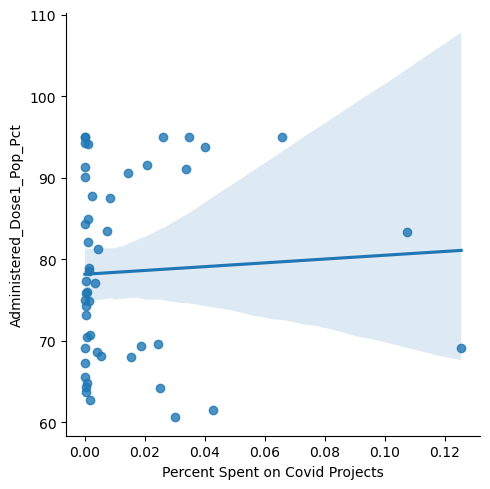

The regression feature is: Count of Vaccine Projects
For x = Count of Vaccine Projects and y = Administered_Dose1_Pop_Pct:
y = 0.12x + 76.0
The R^2 score is: 0.060024552097708184
MSE = 115.21044560443059


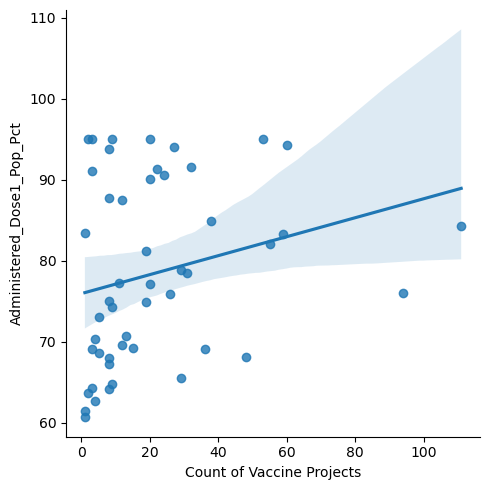

The regression feature is: Total Cumulative Expenditures (millions)
For x = Total Cumulative Expenditures (millions) and y = Administered_Dose1_Pop_Pct:
y = 0.03x + 76.9
The R^2 score is: 0.0938804484308956
MSE = 111.06081285435327


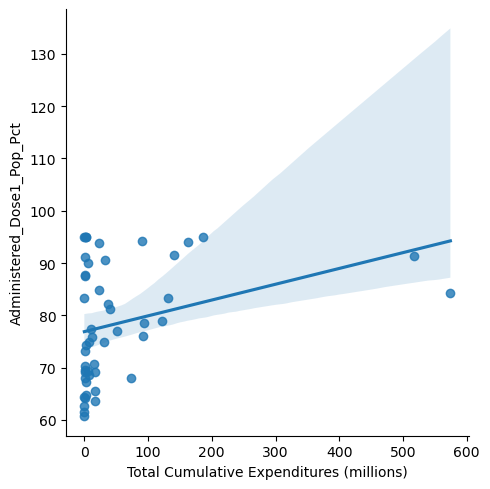

In [48]:
for var in feat_list:
    print(f"The regression feature is: {var}")
    pd_reg_v2(combined_df, var, target)

In [49]:
target = 'Series_Complete_Pop_Pct'

The regression feature is: Percent Spent on Covid Projects
For x = Percent Spent on Covid Projects and y = Series_Complete_Pop_Pct:
y = 18.74x + 67.3
The R^2 score is: 0.002542568508256182
MSE = 90.74346757268282


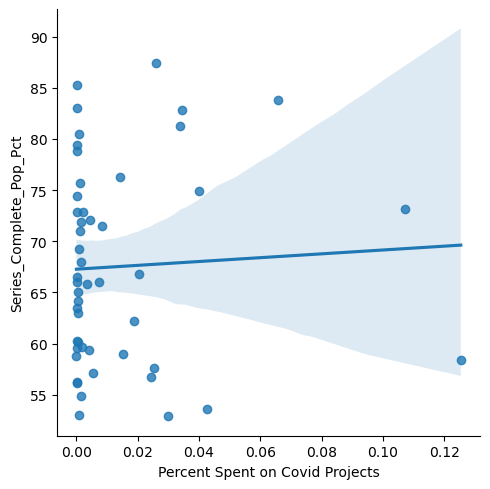

The regression feature is: Count of Vaccine Projects
For x = Count of Vaccine Projects and y = Series_Complete_Pop_Pct:
y = 0.09x + 65.5
The R^2 score is: 0.05136493778883333
MSE = 86.3018634061693


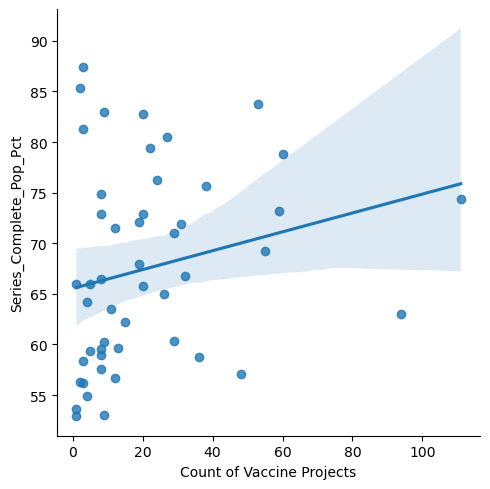

The regression feature is: Total Cumulative Expenditures (millions)
For x = Total Cumulative Expenditures (millions) and y = Series_Complete_Pop_Pct:
y = 0.03x + 66.1
The R^2 score is: 0.10024971094386304
MSE = 81.85458206108254


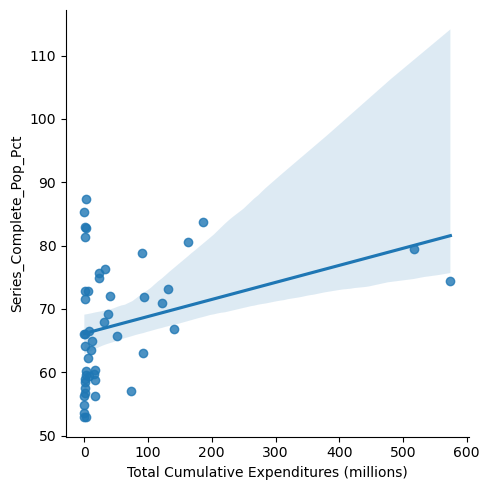

In [50]:
for var in feat_list:
    print(f"The regression feature is: {var}")
    pd_reg_v2(combined_df, var, target)

In [51]:
#Looking at vac_dd_neg_df
vac_dd_neg_fin = vac_dd_neg_df.merge(EARN_states, how = 'inner',on = 'Location')
vac_dd_neg_fin.shape

(34, 26)

In [52]:
feat_list = ['Percent Spent on Covid Projects', 'Count of Vaccine Projects', 'Total Cumulative Expenditures']
target = 'Dose Diff. as Pct of Doses Given'

The regression feature is: Percent Spent on Covid Projects
For x = Percent Spent on Covid Projects and y = Dose Diff. as Pct of Doses Given:
The R^2 score is: 0.004345615008430004


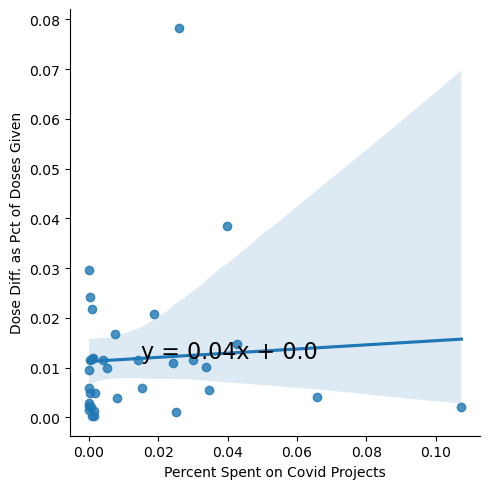

The regression feature is: Count of Vaccine Projects
For x = Count of Vaccine Projects and y = Dose Diff. as Pct of Doses Given:
The R^2 score is: 0.019182485775118163


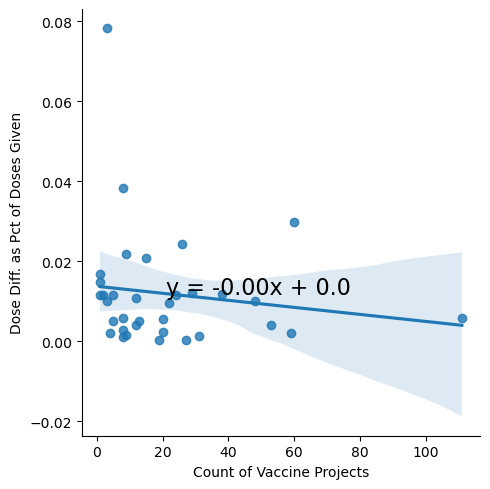

The regression feature is: Total Cumulative Expenditures
For x = Total Cumulative Expenditures and y = Dose Diff. as Pct of Doses Given:
The R^2 score is: 0.01770563087491228


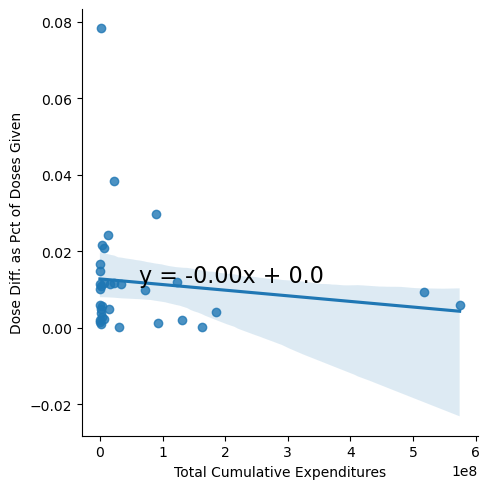

In [53]:
for var in feat_list:
    print(f"The regression feature is: {var}")
    pd_reg(vac_dd_neg_fin, var, target, vac_dd_neg_fin[var].mean(), vac_dd_neg_fin[target].mean())

In [54]:
#Looking at vac_dd_pos_df
vac_dd_pos_fin = vac_dd_pos_df.merge(EARN_states, how = 'inner',on = 'Location')
vac_dd_pos_fin.shape

(16, 26)

In [55]:
target = 'Dose Diff. as Pct of Residents Vaxxed'

The regression feature is: Percent Spent on Covid Projects
For x = Percent Spent on Covid Projects and y = Dose Diff. as Pct of Residents Vaxxed:
The R^2 score is: 0.033919133824771186


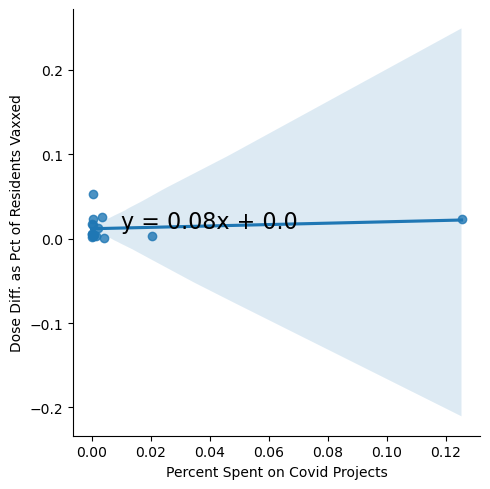

The regression feature is: Count of Vaccine Projects
For x = Count of Vaccine Projects and y = Dose Diff. as Pct of Residents Vaxxed:
The R^2 score is: 0.005664434908494664


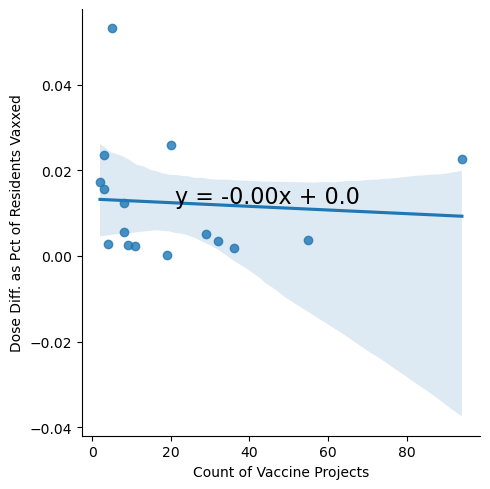

The regression feature is: Total Cumulative Expenditures
For x = Total Cumulative Expenditures and y = Dose Diff. as Pct of Residents Vaxxed:
The R^2 score is: 0.0014451266563161314


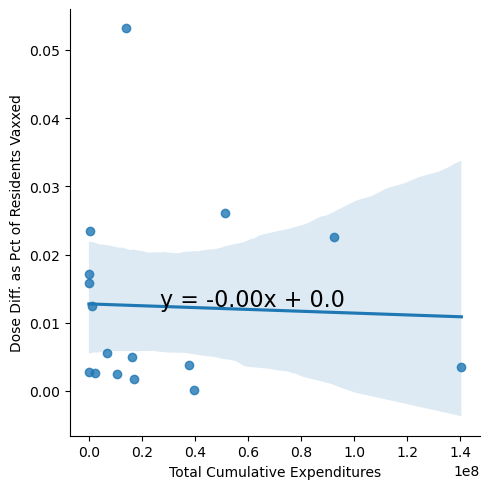

In [56]:
for var in feat_list:
    print(f"The regression feature is: {var}")
    pd_reg(vac_dd_pos_fin, var, target, vac_dd_pos_fin[var].mean(), vac_dd_pos_fin[target].mean())

### *Choropleth Maps -* - Kendal based on original code that Greg found via plotly express module

In [57]:
#determining color range to use for the continuous color scale in choropleth maps for bivalent booster status
choropleth_vac_bivalent = choropleth_vac_df[['Bivalent_Booster_5Plus_Pop_Pct', 
                                             'Bivalent_Booster_12Plus_Pop_Pct', 
                                             'Bivalent_Booster_18Plus_Pop_Pct', 
                                             'Bivalent_Booster_65Plus_Pop_Pct']]
choropleth_vac_bivalent = choropleth_vac_bivalent
min_bivalent_df = choropleth_vac_bivalent.min()
max_bivalent_df = choropleth_vac_bivalent.max()
min_color_range_bivalent = min_bivalent_df.min()
max_color_range_bivalent = max_bivalent_df.max()
print(f"The color range for any bivalent vaccination status choropleth map should be ({min_color_range_bivalent}, {max_color_range_bivalent}).")



The color range for any bivalent vaccination status choropleth map should be (5.6, 62.8).


In [58]:
#determining color range to use for the continuous color scale in choropleth maps for fully vaccinated, and partially or fully vaccinated
choropleth_vac_complete = choropleth_vac_df[['Administered_Dose1_Pop_Pct',
                                             'Series_Complete_Pop_Pct',
                                             'Series_Complete_5PlusPop_Pct', 
                                             'Series_Complete_12PlusPop_Pct', 
                                             'Series_Complete_18PlusPop_Pct', 
                                             'Series_Complete_65PlusPop_Pct']]
choropleth_vac_complete = choropleth_vac_complete
min_df = choropleth_vac_complete.min()
max_df = choropleth_vac_complete.max()
min_color_range = min_df.min()
max_color_range = max_df.max()
print(f"The color range for any complete vaccination choropleth map should be ({min_color_range}, {max_color_range}).")

The color range for any complete vaccination choropleth map should be (52.9, 95.0).


In [59]:
fig_complete_total_pop = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Series_Complete_Pop_Pct',
                    labels={'Series_Complete_Pop_Pct':'% of Population Fully Vaccinated'},
                    color_continuous_scale="viridis_r",
                    range_color=(52,95),
                    title='Vaccination Status by State - Fully Vaccinated'
                    )
fig_complete_total_pop

In [60]:
fig_complete_5plus = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Series_Complete_5PlusPop_Pct',
                    range_color=(52,95),
                    labels={'Series_Complete_5PlusPop_Pct':'% of 5+ Population Fully Vaccinated'},
                    color_continuous_scale="viridis_r",
                    title='Vaccination Status by State - Fully Vaccinated (5+)'
                    )
fig_complete_5plus

In [61]:
fig_complete_12plus = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Series_Complete_12PlusPop_Pct',
                    labels={'Series_Complete_12PlusPop_Pct':'% of 12+ Population Fully Vaccinated'},
                    color_continuous_scale="viridis_r",
                    range_color=(52,95),
                    title='Vaccination Status by State - Fully Vaccinated (12+)'
                    )
fig_complete_12plus

In [62]:
fig_complete_18plus = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Series_Complete_18PlusPop_Pct',
                    labels={'Series_Complete_18PlusPop_Pct':'% of 18+ Population Fully Vaccinated'},
                    color_continuous_scale="viridis_r",
                    range_color=(52,95),
                    title='Vaccination Status by State - Fully Vaccinated (18+)'
                    )
fig_complete_18plus

In [63]:
fig_complete_65_plus = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Series_Complete_65PlusPop_Pct',
                    range_color=(52,95),
                    labels={'Series_Complete_65PlusPop_Pct':'% of 65+ Population Fully Vaccinated'},
                    color_continuous_scale="viridis_r", 
                    title='Vaccination Status by State & Age - Fully Vaccinated (65+)'
                    )
fig_complete_65_plus

In [64]:
fig_at_least_1 = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Administered_Dose1_Pop_Pct',
                    labels={'Administered_Dose1_Pop_Pct':'% of Population Partially or Fully Vaccinated'},
                    color_continuous_scale="viridis_r",
                    range_color=(52,95),
                    title='Vaccination Status by State - Partially or Fully Vaccinated'
                    )
fig_at_least_1

In [65]:
fig_bivalent_booster_5 = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Bivalent_Booster_5Plus_Pop_Pct',
                    labels={'Bivalent_Booster_5Plus_Pop_Pct':'% of 5+ Population with Bivalent Booster'},
                    color_continuous_scale="magma_r",
                    range_color=(5,63),
                    title='Bivalent Booster Status by State - (5+)'
                    )
fig_bivalent_booster_5

In [66]:
fig_bivalent_booster_12 = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Bivalent_Booster_12Plus_Pop_Pct',
                    labels={'Bivalent_Booster_12Plus_Pop_Pct':'% of 12+ Population with Bivalent Booster'},
                    color_continuous_scale="magma_r",  
                    range_color=(5,63),
                    title='Bivalent Booster Status by State - (12+)'
                    )
fig_bivalent_booster_12

In [67]:
fig_bivalent_booster_18 = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Bivalent_Booster_18Plus_Pop_Pct',
                    labels={'Bivalent_Booster_18Plus_Pop_Pct':'% of 18+ Population with Bivalent Booster'},
                    color_continuous_scale="magma_r",  
                    range_color=(5,63),
                    title='Bivalent Booster Status by State - (18+)'
                    )
fig_bivalent_booster_18

In [68]:
fig_bivalent_booster_65 = px.choropleth(choropleth_vac_df,
                    locations='Location',
                    locationmode="USA-states",
                    scope="usa",
                    color='Bivalent_Booster_65Plus_Pop_Pct',
                    labels={'Bivalent_Booster_65Plus_Pop_Pct':'% of 65+ Population with Bivalent Booster'},
                    color_continuous_scale="magma_r",  
                    range_color=(5,63),
                    title='Bivalent Booster Status by State - (65+)'
                    )
fig_bivalent_booster_65

In [69]:
#boxplots showing spread of data across all 50 states and DC for selected columns
boxplot = vac_df.boxplot(column=['Series_Complete_Pop_Pct', 
                                 'Administered_Dose1_Pop_Pct', 
                                 'Series_Complete_65PlusPop_Pct', 
                                 'Bivalent_Booster_65Plus_Pop_Pct'], 
                         grid=True,
                         figsize = (20,15),
                        )
plt.title("Distribution of Vaccination Rates Across U.S. States")
plt.xticks([1, 2, 3, 4], ['% Pop. Fully Vaccinated', '% Pop. Partially  or Fully Vaccinated', '% Pop. Fully Vaccinated - 65+', '% Pop. Bivalent Booster - 65+'])
plt.savefig('Resources/boxplot.png')

In [70]:
#finding percentage of all projects that fall in each of the 7 expenditure category groups
spending_overall = all_us_projects_df.groupby('Expenditure Category Group').count()
total_projects = spending_overall['State'].sum()
categories_percentage_overall = (spending_overall['State']/total_projects)*100
categories_percentage_overall = pd.DataFrame(categories_percentage_overall)
categories_percentage_overall.rename(columns={'State': '% of Total Projects'}, inplace=True)
#categories_percentage_overall = categories_percentage_overall.reset_index()
categories_percentage_overall

% of Total Projects
Expenditure Category Group                                             
1-Public Health                                               19.971433
2-Negative Economic Impacts                                   26.286899
3-Public Health-Negative Economic Impact: Publi...             6.360276
4-Premium Pay                                                  2.117291
5-Infrastructure                                              13.762393
6-Revenue Replacement                                         26.502549
7-Administrative                                               4.999160

In [71]:
#finding percentage of covid-related projects that fall in each of the 7 expenditure category groups
spending_covid_project = covid_projects_df.groupby("Expenditure Category Group").count()
total_projects_covid = spending_covid_project['Recipient Name'].sum()
categories_percentage_covid = (spending_covid_project['Recipient Name']/total_projects_covid)*100
categories_percentage_covid = pd.DataFrame(categories_percentage_covid)
categories_percentage_covid.rename(columns={'Recipient Name':'% of Covid Projects'}, inplace=True)
categories_percentage_covid.reset_index()

Expenditure Category Group  % of Covid Projects
0                                    1-Public Health            71.324201
1                        2-Negative Economic Impacts             5.479452
2  3-Public Health-Negative Economic Impact: Publ...             9.954338
3                                      4-Premium Pay             1.826484
4                                   5-Infrastructure             0.182648
5                              6-Revenue Replacement             9.954338
6                                   7-Administrative             1.278539

In [72]:
#plotting expenditure categories - all projects
overall_spend_group = categories_percentage_overall['% of Total Projects']
categories_percentage_overall['Category']=['Public Health', 'Negative Economic Impacts', 'Public Health - Neg. Ec. Imp.', 'Premium Pay', 'Infrastructure', 'Revenue Replacement', 'Administrative']
plt.pie(overall_spend_group, autopct='%1.0f%%', radius=2)
plt.legend(categories_percentage_overall['Category'],
           loc="center right",
           title='All Projects',
           bbox_to_anchor=(1.6, 0, 0.5, 1))
plt.savefig('Resources/category_spending_all', bbox_inches = 'tight')

In [73]:
#plotting expenditure categories - covid projects
covid_spend_group = categories_percentage_covid['% of Covid Projects']
categories_percentage_overall['Category']=['Public Health', 'Negative Economic Impacts', 'Public Health - Neg. Ec. Imp.', 'Premium Pay', 'Infrastructure', 'Revenue Replacement', 'Administrative']
plt.pie(covid_spend_group, autopct='%1.0f%%', radius=2)
plt.legend(categories_percentage_overall['Category'],
           loc="center right",
           title='Covid Projects',
           bbox_to_anchor=(1.6, 0, 0.5, 1))
plt.savefig('Resources/category_spending_covid', bbox_inches = 'tight')
